# Продвинутая модель и поиск гиперпараметров

### Цели
- выбор модели: CatBoost / LightGBM / XGBoost.
- поиск 5–10 конфигураций (Grid/Random/SearchCV) с сохранением лога результатов.
- сравнение с baseline, выбор «победителя».

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import pickle

# Загрузка данных
data_path = '../data/interim/data_split.pkl'
baseline_path = '../data/interim/baseline_models_results.pkl'
with open(data_path, 'rb') as f:
    data = pickle.load(f)
    
y_train, y_valid, y_test = data['y_train'], data['y_valid'], data['y_test']
X_train = data['X_train_processed']
X_valid = data['X_valid_processed']
X_test = data['X_test_processed']

with open(baseline_path, 'rb') as f:
    baseline = pickle.load(f)
    
# baseline_metrics = pd.read_csv('../data/interim/baseline_metrics.csv')
baseline_metrics = baseline['best_baseline']['metrics']
baseline_f1 = baseline_metrics['f1']
baseline_roc_auc = baseline_metrics['roc_auc']
baseline_pr_auc = baseline_metrics['pr_auc']

## Выбор гиперпараметров продвинутой модели

### Выбираем лучшую конфигурацию по F1 по следующим гиперпараметрам:
- depth - глубина деревьев
- learning_rate - скорость обучения
- iterations - количество деревьев
- l2_leaf_reg - коэффициент L2-регуляризации


In [69]:
feature_names = data['feature_names']
X_train = pd.DataFrame(X_train, columns=feature_names)
X_valid = pd.DataFrame(X_valid, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Гиперпараметры
params = {
     'depth': [3, 5, 7, 9],
     'learning_rate': [0.01, 0.05, 0.1, 0.2],
     'iterations': [10, 100, 150, 200],
     'l2_leaf_reg': [3, 7, 10, 13]
}
    
# Создание модели CatBoost
catboost_model = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')

# Поиск гиперпараметров
random_search = RandomizedSearchCV(
    catboost_model, 
    params,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("\nЛучшие параметры для CatBoost:")
print(random_search.best_params_)
print(f"\nЛучший F1-score на тренировочной выборке: {random_search.best_score_:.4f}")


Лучшие параметры для CatBoost:
{'learning_rate': 0.1, 'l2_leaf_reg': 13, 'iterations': 100, 'depth': 3}

Лучший F1-score на тренировочной выборке: 0.6602


## Расчет метрик

In [70]:
# Предсказания лучшей модели
model = random_search.best_estimator_
y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# Расчет метрик
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)
pr_auc = average_precision_score(y_valid, y_pred_proba)
cm = confusion_matrix(y_valid, y_pred)
print("Метрики валидационной выборки:\n")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"Матрица ошибок:\n{cm}\n")
print(classification_report(y_valid, y_pred, target_names=['Нет диабета', 'Диабет']))

Метрики валидационной выборки:

F1 Score: 0.7167
ROC-AUC: 0.8689
PR-AUC: 0.7632
Матрица ошибок:
[[77 23]
 [11 43]]

              precision    recall  f1-score   support

 Нет диабета       0.88      0.77      0.82       100
      Диабет       0.65      0.80      0.72        54

    accuracy                           0.78       154
   macro avg       0.76      0.78      0.77       154
weighted avg       0.80      0.78      0.78       154



## Визуализация

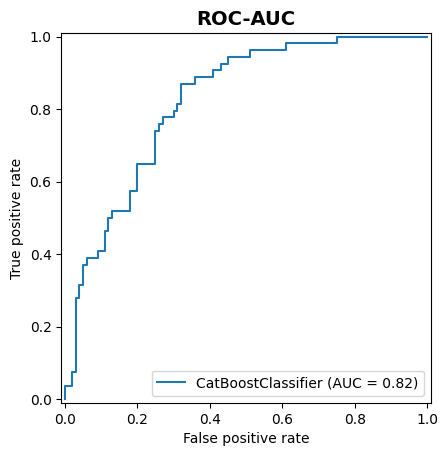

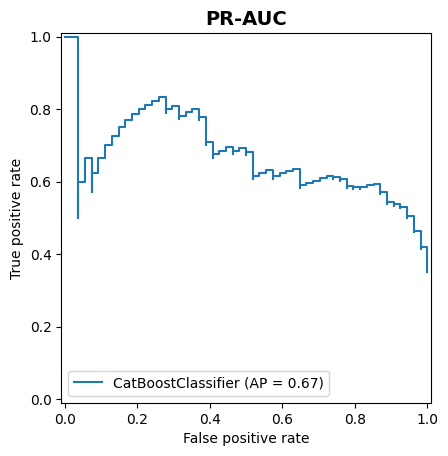

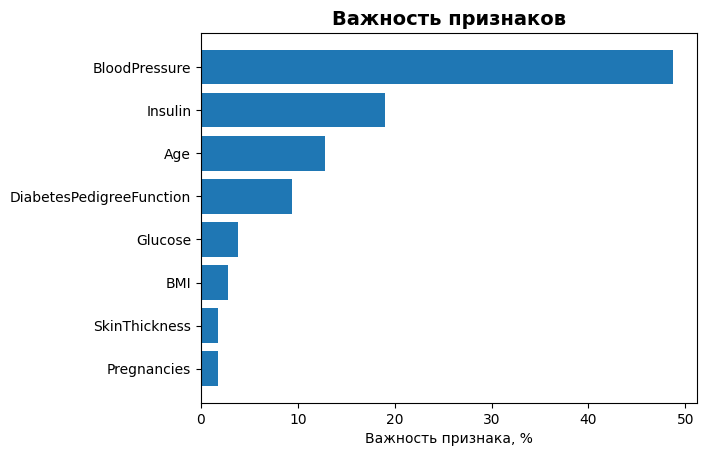

In [71]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC-AUC', fontsize=14, fontweight='bold')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('PR-AUC', fontsize=14, fontweight='bold')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

feature_importance = model.feature_importances_
importance = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importance
}).sort_values('Важность', ascending=True)

plt.barh(importance['Признак'], importance['Важность'])
plt.xlabel('Важность признака, %')
plt.title('Важность признаков', fontsize=14, fontweight='bold')
plt.show()


# Сравнение моделей

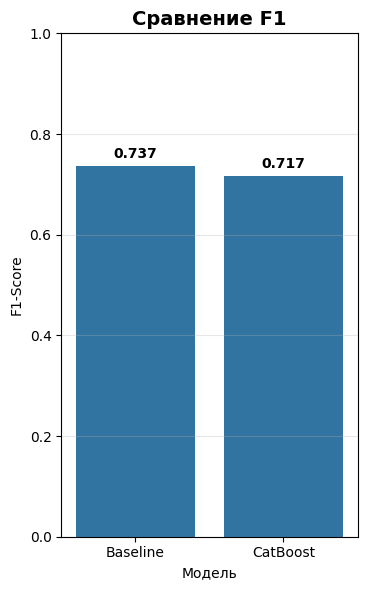

In [72]:
# Сравнение моделей
comparison = pd.DataFrame({
    'Модель': ['Baseline', 'CatBoost'],
    'F1-Score': [baseline_f1, f1],
    'ROC-AUC': [baseline_roc_auc, roc_auc],
    'PR-AUC': [baseline_pr_auc, pr_auc]
})

# Сравнение метрик
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.title('Сравнение F1', fontsize=14, fontweight='bold')
sns.barplot(data=comparison.reset_index(), x='Модель', y='F1-Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison['F1-Score']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

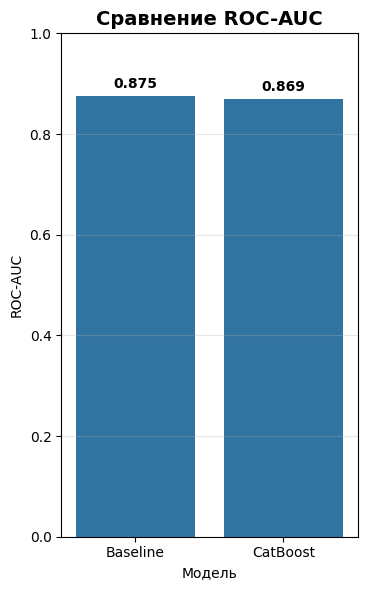

In [73]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.title('Сравнение ROC-AUC', fontsize=14, fontweight='bold')
sns.barplot(data=comparison.reset_index(), x='Модель', y='ROC-AUC')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(comparison['ROC-AUC']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

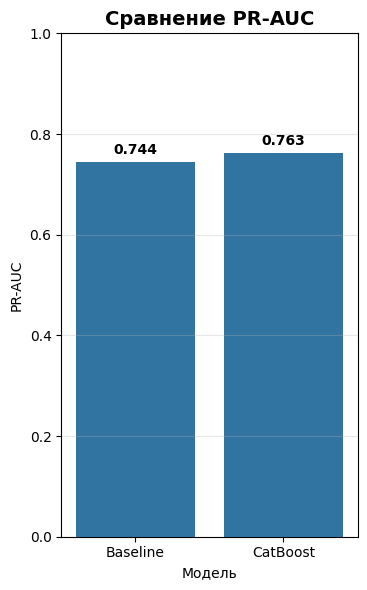

In [74]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.title('Сравнение PR-AUC', fontsize=14, fontweight='bold')
sns.barplot(data=comparison.reset_index(), x='Модель', y='PR-AUC',)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(comparison['PR-AUC']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Анализ сравнения продвинутой модели

#### F1-Score:
У CatBoost наблюдается снижение основного показателя на 2%

#### ROC-AUC: 
Незначительное снижение на 0.6%, что означает сопоставимое разделение классов.

#### PR-AUC: 
CatBoost показал улучшение на 1.9%, что означает лучшую работу на несбалансированных данных

In [76]:
# Лог результатов поиска гиперпараметров
results_log = pd.DataFrame(random_search.cv_results_)
results_log.to_csv('../data/interim/catboost_search_log.csv', index=False)

# Сохранение модели CatBoost
model.save_model('../data/interim/catboost_model.cbm')

## Итоговые выводы

### Положительные стороны CatBoost
- Высокий True Negative, то есть модель хорошо идентифицирует отрицательные классы
- Низкий False Negative, то есть модель мало пропускает положительные случаи, что особенно важно в медицине
- CatBoost показал улучшение PR-AUC, что означает лучшую работу на несбалансированных данных.

### Почему CatBoost не показал значительного улучшения по сравнению с baseline (Decision Tree)?
- Мы используем уже обработанный датасет, а Decision Tree эффективен на обработанных данных с четкими разделяющими границами
- CatBoost использует сложные алгоритмы, которые переусложняют нашу простую задачу
- Недостаточная настройка параметров модели.
  
### Когда выбирать CatBoost?
  - при работе с категориальными признаками
  - при необходимости устойчивости к переобучению
  - для задач с высокими требованиями к PR-AUC.

### Когда лучше Decision Tree?
  - при ограниченных вычислительных ресурсах
  - для интерпретируемости модели
  - если F1-Score является ключевой метрикой.